## Q-learning 예제

### Jack의 랜터카 사업 문제

- Jack은 전국적인 렌터카 회사의 두 지점을 관리하고 있습니다. 매일 몇 명의 고객이 각 지점에 도착하여 각 지점을 방문합니다.

- 잭은 사용 가능한 차량이 있는 경우 차량을 대여하고 전국 회사로부터 10달러의 크레딧을 받습니다.

- 만약 해당 지점에 차량이 없다면, 사업을 잃게 됩니다.

- 자동차는 반납한 다음 날부터 다시 대여할 수 있습니다.

- 잭은 필요한 곳에 자동차를 사용할 수 있도록 하기 위해 하룻밤 사이에 두 지점 간에 자동차를 이동시킬 수 있으며, 이동한 자동차당 2달러의 비용을 지불해야 합니다.

- 각 위치에서 요청된 차량과 반납된 차량의 수는 푸아송 분포를 따르며,

- A 직영점에서의 (대여, 반납)에 대한 푸아송 기대치는 (3, 3)이다.

  - 대여-반납이 대부분 동일하게 유지된다.

- B 직영점에서의 (대여, 반남)에 대한 푸아송 기대치는 (4, 2)이다.

  - 반납보다 대여가 더 많으므로 차량을 계속 공급해야 한다.

- 각 위치에서 20대를 초과하는 차량이 있을 수 없다고 가정합니다.

- 최대 하룻밤에 한 위치에서 다른 위치로 최대 5대의 차량을 이동할 수 있다고 가정합니다.

- 우리는 할인율을 γ = 0.9로 가정하고 이를 연속 유한 MDP로 공식화합니다.

- 여기서 시간 단계는 일이고,

- 상태는 각 위치의 차량 수입니다.

- 하루가 끝날 때, 그리고 행동은 하룻밤 동안 두 위치 간에 이동한 순 차량 수입니다.

### 필요한 모듈 임포트

In [52]:
import numpy as np
import matplotlib.pyplot as plt

from typing import List

### 액션 정의: 직영점 간 하루 몇 대의 차를 옮길 것인가?

- 최대 5대의 차를 얻거나 잃을 수 있으므로, 총 11가지의 액션이 있음

In [53]:
actions: np.ndarray = np.arange(-5, 5 + 1)

### 상태 함수

- 모든 가능한 주차된 차 수의 조합

$states = \{A, B | (0, 0), (0, 1), ..., (0, 20), (1, 0), (1, 1), ..., (1, 20), ..., (20, 20)\}$

In [37]:
# A 직영점과 B 직영점의 모든 가능한 주차된 차 수의 조합
states: List[List[int]] = []

for a_cars in range(20 + 1):
    for b_cars in range(20 + 1):
        states.append([a_cars, b_cars])


### 가치 함수

- 각 직영점이 가질 수 있는 경우의 수는 21가지, 모든 환경에 대응하는 행렬의 크기는 21 x 21

$Value$는 21 x 21 크기의 영행렬

In [57]:
#현재 시점의 가치
value: np.ndarray = np.zeros((20 + 1, 20 + 1))
# 다음 시점의 가치
new_value: np.ndarray = np.zeros((20 + 1, 20 + 1))

### 정책 초기화

In [58]:
policy: np.ndarray = np.zeros((20 + 1, 20 + 1))
new_policy: np.ndarray = np.zeros((20 + 1,20 + 1))

### 메모이제이션을 적용한 포아송 분포 메서드 정의

In [59]:
from math import factorial

p_dict: dict[tuple, float] = {}

def poisson_distribution(x: int, lamb: int) -> float:
    global p_dict

    key: tuple[int] = (x, lamb)
    if key not in p_dict.keys():
        p_dict[key] = lamb ** x * np.exp(-lamb)/factorial(x)

    return p_dict[key]

### 가치 함수 업데이트

In [61]:
# 이 범위를 넘어설 확률은 극히 희박하다 캄
poisson_upper_bound: int = 8 + 1

# gamma는 할인율
def calculate_nextV_function(state, action, state_value, gamma = 0.9):
    global poisson_upper_bound

    # 현재 취한 행동으로 인한 보상 감소를 미리 대입해 둠, 보상은 차량 이동량마다 -2씩 부여
    returns = -2 * np.abs(action)

    # 현재 취한 행동으로 인한 차량 대수의 변화 계산
    # action값이 양수인 경우 A -> B로의 차량 이동이고, 음수인 경우 그 반대로의 이동
    # 다만 각 직영점의 최소 차량 수는 0대이고, 최대 차량 수는 20대이므로 그 범위를 지정
    A_cars = int(max(min(state[0] - action, 20), 0))
    B_cars = int(max(min(state[1] + action, 20), 0))

    # 모든 경우 탐색
    # A에서 랜트
    for rentA in range(poisson_upper_bound):
        # B에서 랜트
        for rentB in range(poisson_upper_bound):
            # A에서 반납
            for returnA in range(poisson_upper_bound):
                # B에서 반납
                for returnB in range(poisson_upper_bound):
                    # A, B 직영점에서 랜트하는 확률
                    # 두 사건은 독립적이므로 곱해서 총 확률을 구함
                    rent_prob = poisson_distribution(rentA, 3) * poisson_distribution(rentB, 4)

                    # 두 직영점에서 대여된 차량 수
                    # 대여된 차량 수는 각 직영점의 현재 차량 수를 초과할 수 없음
                    Alot_rent_fin = min(A_cars, rentA)
                    Blot_rent_fin = min(B_cars, rentB)

                    # 보상
                    reward = (Alot_rent_fin + Blot_rent_fin) * 10

                    # A, B 직영점에 반납하는 확률
                    # 두 사건은 독립적
                    return_prob = poisson_distribution(returnA, 3) * poisson_distribution(returnB, 2)

                    # 상태 변화 후의 차량 수를 구함
                    next_A_cars = int(max(min(A_cars - Alot_rent_fin + returnA, 20), 0))
                    next_B_cars = int(max(min(B_cars - Blot_rent_fin + returnB, 20), 0))

                    # 이상의 상태 변화가 일어날 총 확률
                    total_prob = rent_prob * return_prob

                    # 정책 평가 식을 이용하여 최종 기댓값과 가치 함수를 구함
                    returns += total_prob * (reward + gamma * state_value[next_A_cars, next_B_cars])

    return returns

### 정책, 가치 함수 업데이트

In [42]:
# 각 이터레이션에 해당하는 정책과 가치 함수를 저장할 리스트
iter_policy = []
iter_value = []

# 초기 정책 및 가치 저장(21*21크기의 영행렬)
iter_policy.append(policy)
iter_value.append(value)

In [43]:
iteration = 0

#while True:
while iteration != 10:
    print(f"iteration {iteration + 1}")

    for stateA, stateB in states:
        # 현재 상태 stateA, stateB
        action_buffer = []

        # 현재 상태에서 취할 수 있는 모든 행동을 취함
        for action in actions:
            if((stateA >= action and action >= 0) or (action < 0 and stateB >= np.abs(action))):
                action_buffer.append(calculate_nextV_function([stateA, stateB], action, value))
            else:
                action_buffer.append(-np.inf)

        # 그리디 알고리즘으로 가장 큰 가치를 보인 행동을 선택하고, 새 정책에 그 행동을 설정
        action_idx = np.argmax(action_buffer)
        new_policy[stateA, stateB] = actions[action_idx]

        # 선택된 행동에 대한 새 가치 함수 계산
        new_value[stateA, stateB] = calculate_nextV_function([stateA, stateB], actions[action_idx], value)

    iteration += 1

    if np.sum(policy!=new_policy) < 1e-04:
        break

    value = new_value.copy()
    policy = new_policy.copy()

    iter_policy.append(policy)
    iter_value.append(value)


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10


Text(0.5, 1.0, 'Policy')

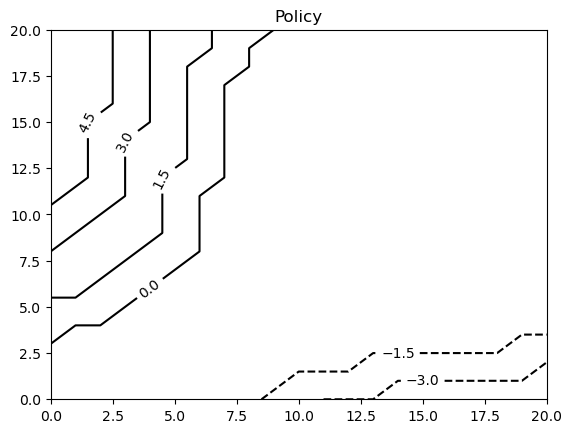

In [48]:
fig,ax = plt.subplots()
cs = ax.contour(policy, colors='k')
ax.clabel(cs,inline=1,fontsize=10)
ax.set_title("Policy")

Text(0.5, 1.0, 'Expected return')

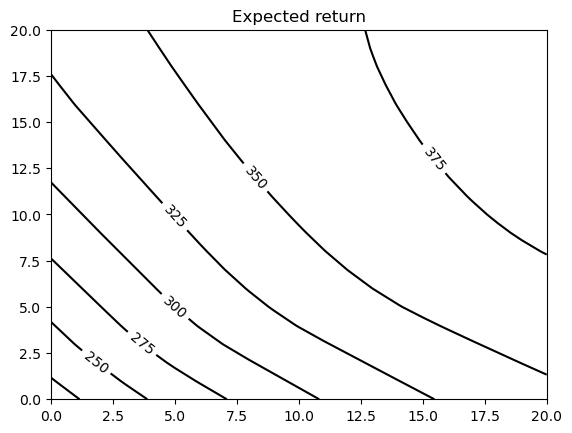

In [49]:
fig,ax = plt.subplots()
cs = ax.contour(value,colors='k')
ax.clabel(cs,inline=1,fontsize=10)
ax.set_title("Expected return")

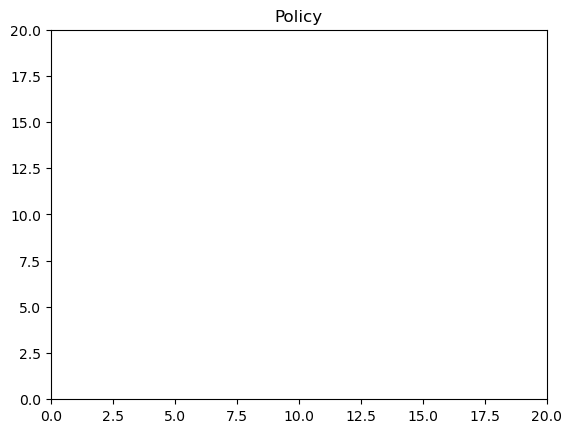

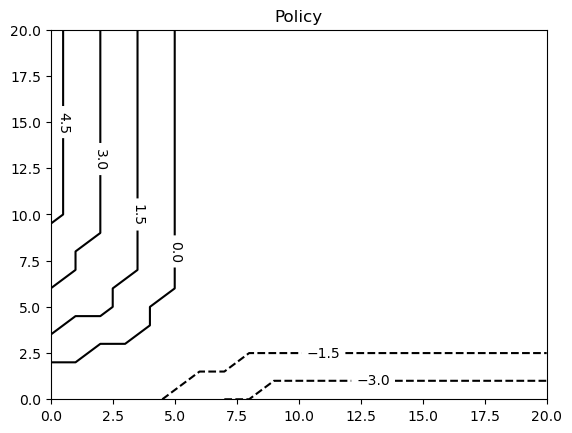

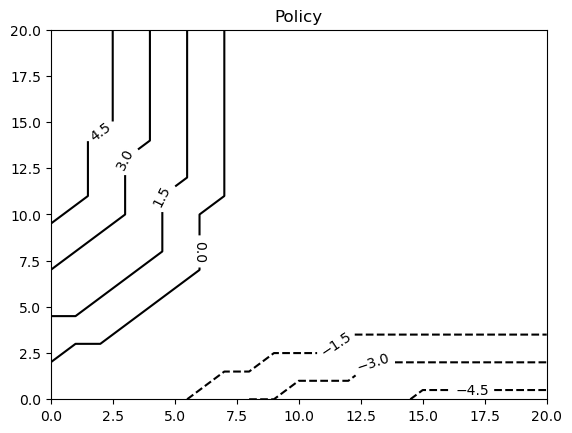

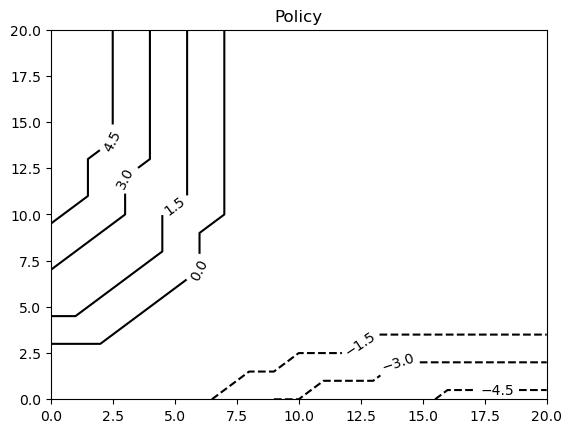

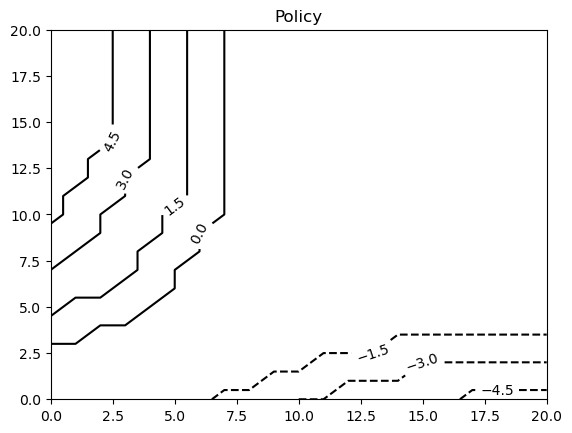

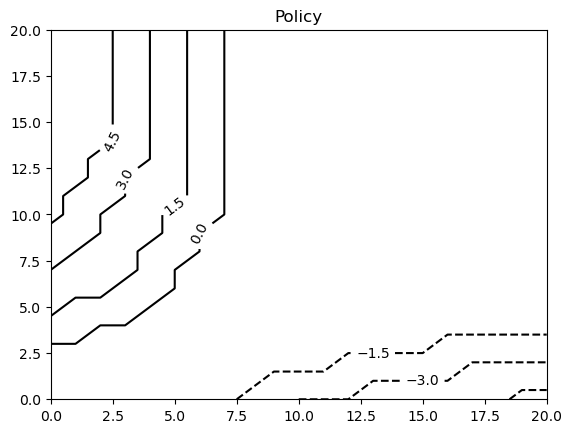

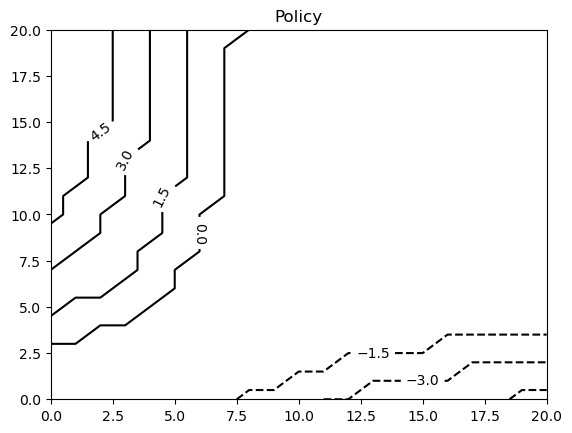

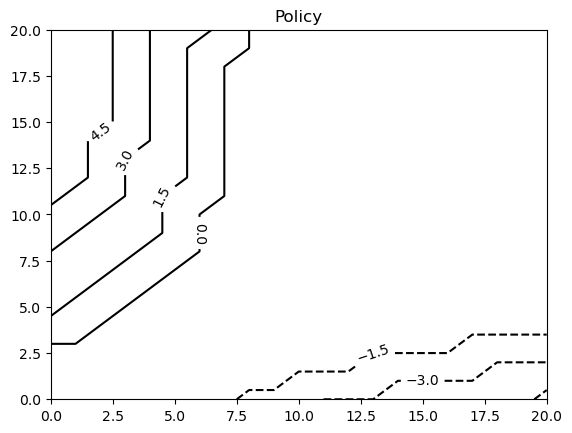

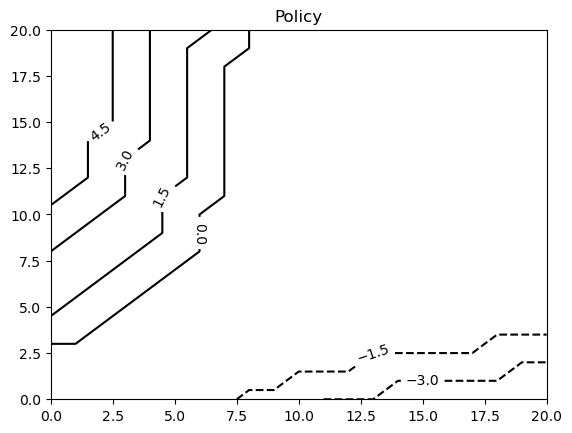

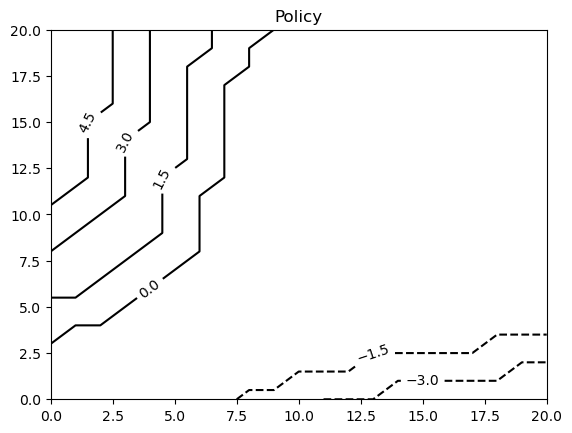

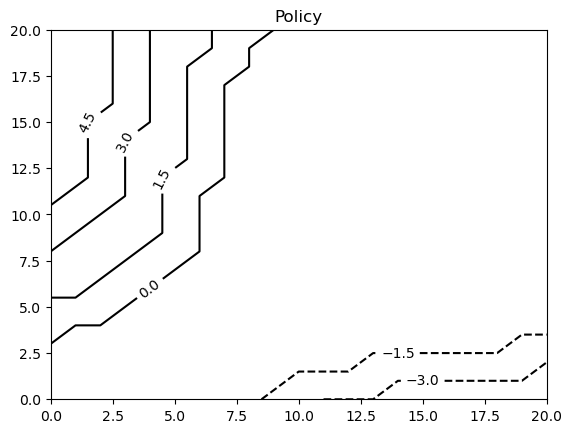

In [50]:
for ip in iter_policy:
    fig,ax = plt.subplots()
    cs = ax.contour(ip,colors='k')
    ax.clabel(cs,inline=1,fontsize=10)
    ax.set_title("Policy")

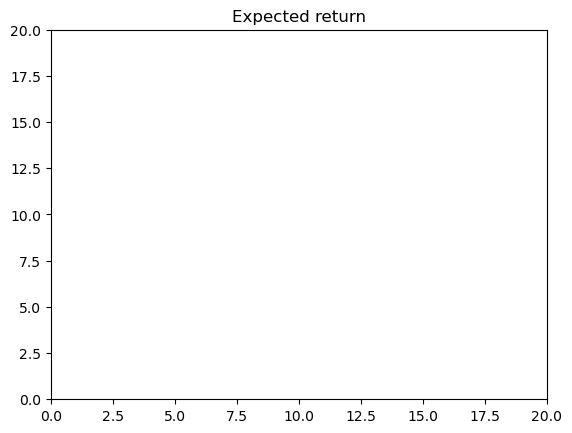

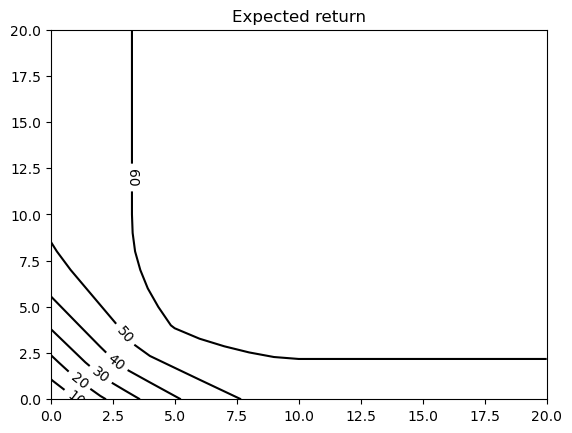

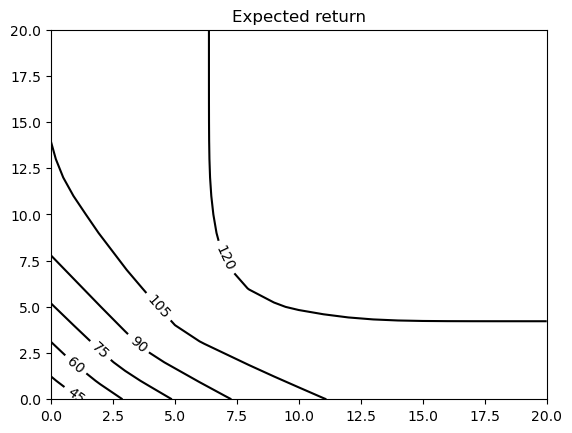

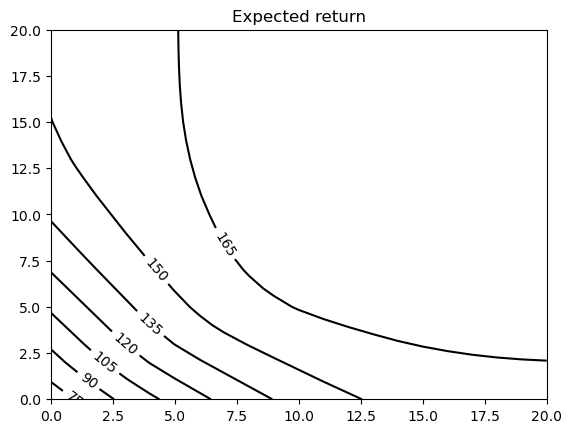

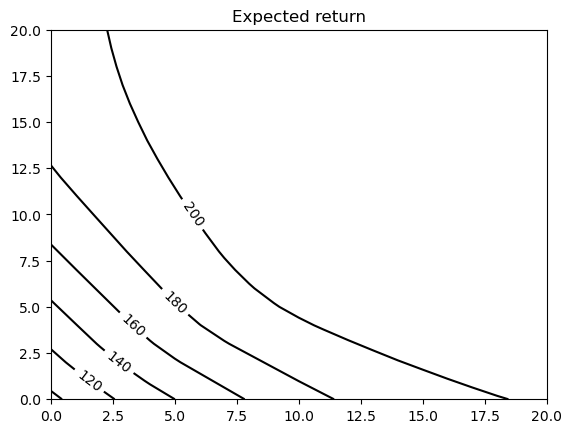

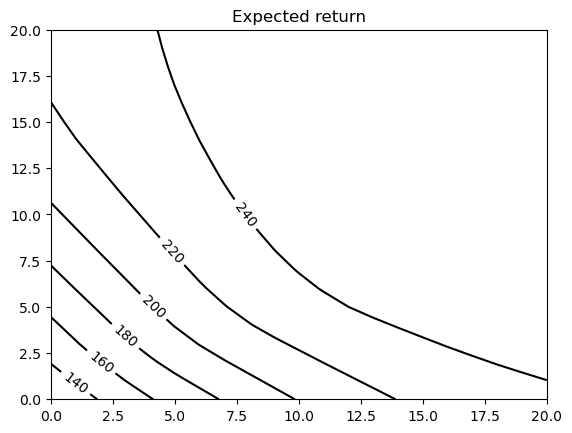

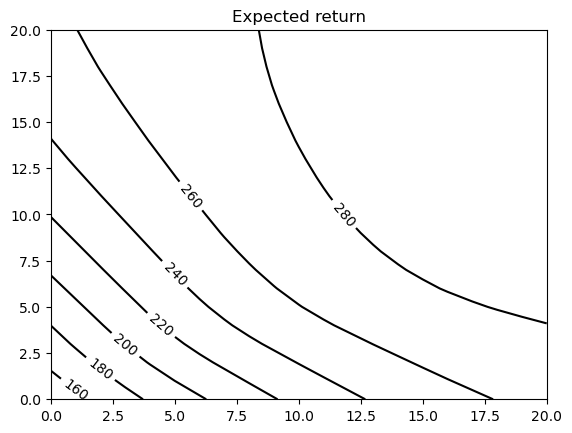

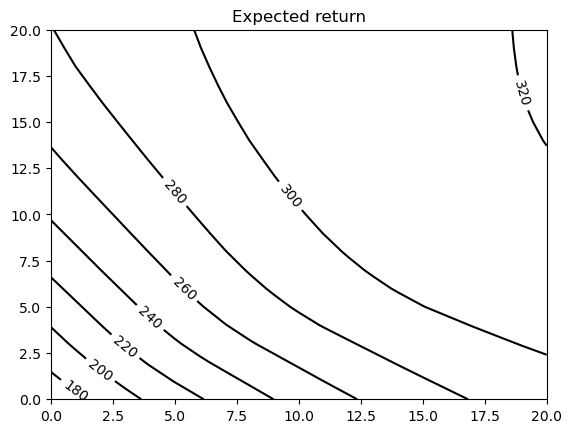

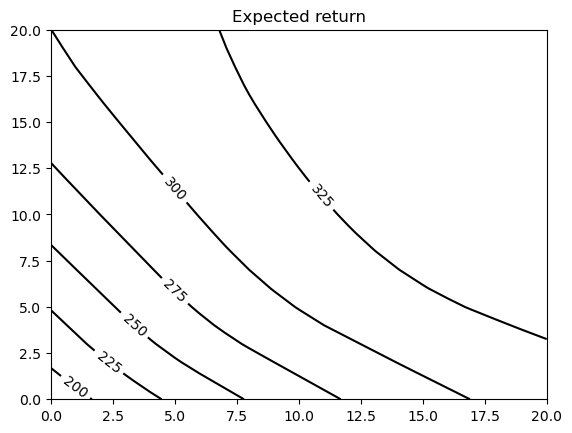

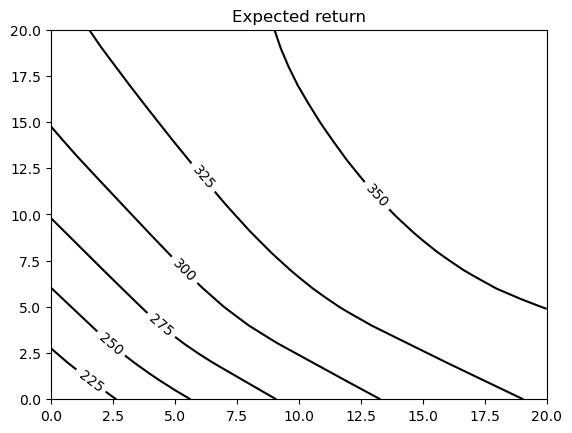

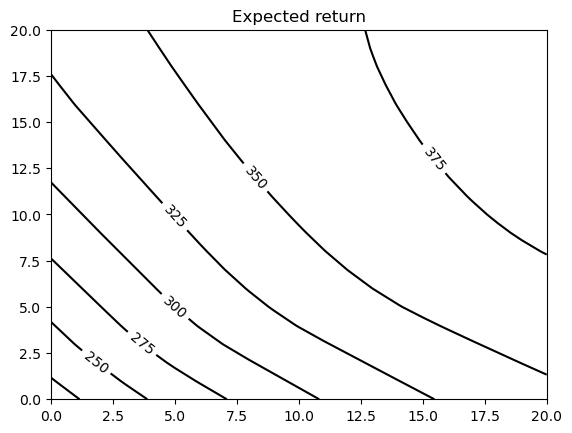

In [51]:
for iv in iter_value:
    fig,ax = plt.subplots()
    cs = ax.contour(iv,colors='k')
    ax.clabel(cs,inline=1,fontsize=10)
    ax.set_title("Expected return")